In [56]:
import pandas as pd
import yfinance as yf

# Define the symbol for SOXX ETF
symbol = 'SOXX'

# Calculate the end date as today
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

# Calculate the start date as 10 years before the end date
start_date = (pd.Timestamp.today() - pd.DateOffset(years=10)).strftime('%Y-%m-%d')

# Fetch historical stock data for SOXX
etf_data = yf.download(symbol, start=start_date, end=end_date)['Adj Close']

# Create a DataFrame for the ETF
etf_df = pd.DataFrame(etf_data)

# Ensure the column name is corrected if necessary
if symbol not in etf_df.columns:
    etf_df.rename(columns={etf_df.columns[0]: symbol}, inplace=True)

# Add a column for the number of shares (Assuming 1000 shares for the ETF)
etf_df['Shares_SOXX'] = 1000

# Calculate the value of the ETF holdings in USD
etf_df['ETF_Value'] = etf_df[symbol] * etf_df['Shares_SOXX']

# Round the ETF value column to 2 decimal places
etf_df = etf_df.round({symbol: 2, 'ETF_Value': 2})

# Print the first few rows of the ETF DataFrame
display(etf_df.head())
display(etf_df.tail())





[*********************100%%**********************]  1 of 1 completed


,SOXX,Shares_SOXX,ETF_Value
Date,,,
2014-03-28,18.42,1000,18418.52
2014-03-31,18.72,1000,18719.20
2014-04-01,19.02,1000,19017.52
2014-04-02,18.99,1000,18989.33
2014-04-03,19.02,1000,19017.52


,SOXX,Shares_SOXX,ETF_Value
Date,,,
2024-03-21,225.18,1000,225179.99
2024-03-22,225.45,1000,225450.00
2024-03-25,224.57,1000,224570.01
2024-03-26,222.88,1000,222880.00
2024-03-27,225.68,1000,225679.99


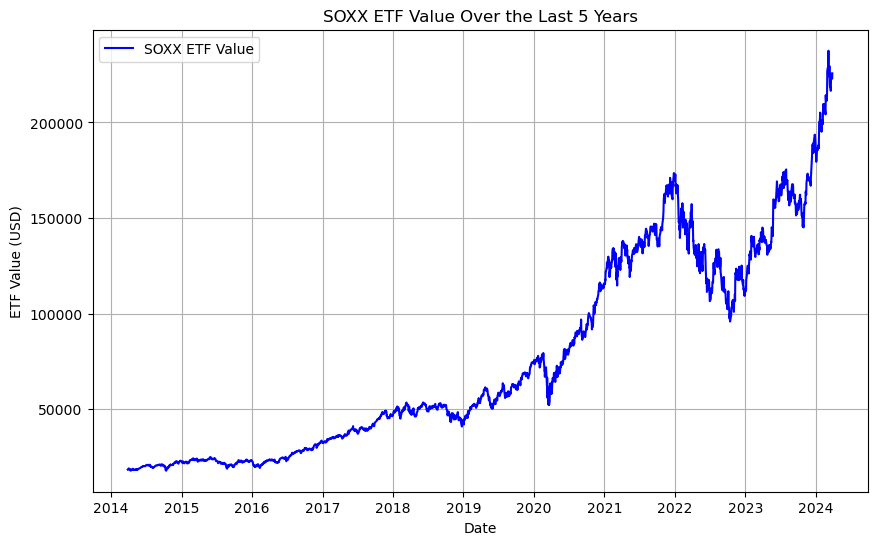

In [57]:
import matplotlib.pyplot as plt
# Plot the ETF Value
plt.figure(figsize=(10, 6))

plt.plot(etf_df.index, etf_df['ETF_Value'], label='SOXX ETF Value', color='blue')

plt.title('SOXX ETF Value Over the Last 5 Years')
plt.xlabel('Date')
plt.ylabel('ETF Value (USD)')
plt.legend()
plt.grid(True)
plt.show()


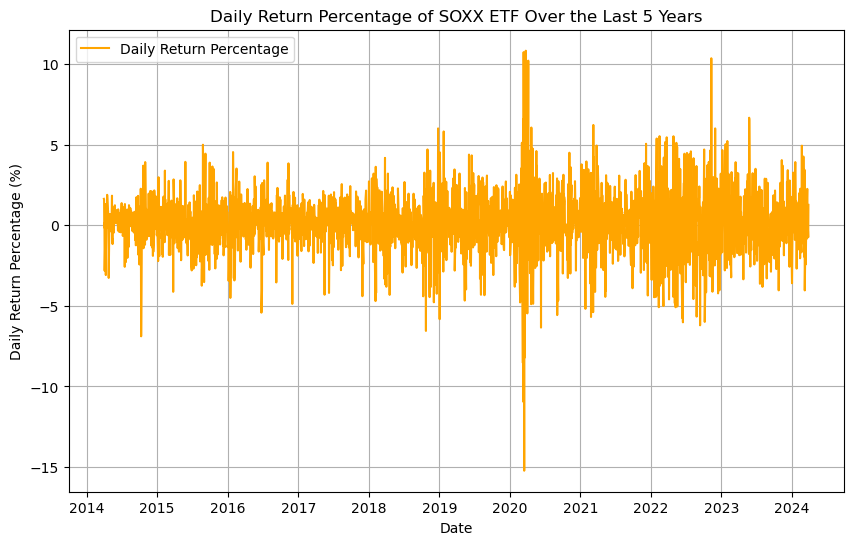

In [58]:

# Calculate daily percentage change in ETF value
etf_df['Daily_Return_Percentage'] = etf_df['ETF_Value'].pct_change() * 100

plt.figure(figsize=(10, 6))
plt.plot(etf_df.index, etf_df['Daily_Return_Percentage'], label='Daily Return Percentage', color='orange')
plt.title('Daily Return Percentage of SOXX ETF Over the Last 5 Years')
plt.xlabel('Date')
plt.ylabel('Daily Return Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()


In [59]:
# Calculate daily percentage change in ETF value and add it as a new column
etf_df['Daily_Return_Percentage'] = etf_df['ETF_Value'].pct_change()

# Print the first few rows of the ETF DataFrame
etf_df

,SOXX,Shares_SOXX,ETF_Value,Daily_Return_Percentage
Date,,,,
2014-03-28,18.42,1000,18418.52,NaN
2014-03-31,18.72,1000,18719.20,0.016325
2014-04-01,19.02,1000,19017.52,0.015937
2014-04-02,18.99,1000,18989.33,-0.001482
2014-04-03,19.02,1000,19017.52,0.001485
...,...,...,...,...
2024-03-21,225.18,1000,225179.99,0.022500
2024-03-22,225.45,1000,225450.00,0.001199
2024-03-25,224.57,1000,224570.01,-0.003903


In [60]:
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import numpy as np

# Define the symbol for SOXX ETF
symbol = 'SOXX'

# Calculate the end date as today
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

# Calculate the start date as 5 years before the end date
start_date = (pd.Timestamp.today() - pd.DateOffset(years=5)).strftime('%Y-%m-%d')

# Fetch historical stock data for SOXX
etf_data = yf.download(symbol, start=start_date, end=end_date)['Adj Close']

# Create a DataFrame for SOXX
soxx_df = pd.DataFrame(etf_data)

# Calculate the value of the SOXX holdings (assuming 1000 shares)
soxx_df['ETF_Value'] = soxx_df['Adj Close'] * 1000

# Calculate daily percentage change in ETF value
soxx_df['Daily_Return_Percentage'] = soxx_df['ETF_Value'].pct_change() * 100

# Drop NaN values resulting from the calculation
soxx_df.dropna(inplace=True)

# Feature Extraction
soxx_df['Previous_Return'] = soxx_df['Daily_Return_Percentage'].shift(1)
soxx_df['Rolling_Mean'] = soxx_df['Daily_Return_Percentage'].rolling(window=7).mean()
soxx_df['Rolling_Std'] = soxx_df['Daily_Return_Percentage'].rolling(window=7).std()

# Drop NaN values resulting from rolling calculations and lagged values
soxx_df.dropna(inplace=True)

# Split data into training and testing sets
X = soxx_df[['Previous_Return', 'Rolling_Mean', 'Rolling_Std']]
y = soxx_df['Daily_Return_Percentage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
r2_score = model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)

print("R^2 Score:", r2_score)
print("Mean Absolute Error:", mae)

# Predict future daily return percentages for the next 30 days
last_features = X.tail(1)
next_30_days = pd.date_range(start=soxx_df.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
future_features = pd.DataFrame(index=next_30_days, columns=X.columns)
future_features.iloc[0] = last_features.values[0]

for i in range(1, 30):
    future_features.iloc[i] = np.concatenate(([future_features.iloc[i - 1][0]], np.random.rand(2)))

future_predictions = model.predict(future_features)
print("Future Predictions for the next 30 days:")
print(future_predictions)


[*********************100%%**********************]  1 of 1 completed

R^2 Score: 0.07239919238441905
Mean Absolute Error: 1.293806098182675
Future Predictions for the next 30 days:
[ 0.75119602  0.78248973  1.18242794  1.15371302 -0.03297381  0.39884893
  0.67908868  1.25313445  0.22696855  0.5549586   0.93979322  0.31323813
  1.14553556 -0.03576383  1.11521549  0.49753884  0.03330754  0.42848766
  0.60142935  0.64841994  1.03518346  0.78784746  0.77574082  1.41602851
  0.12654075  0.94387418  1.02750318  0.77773676  1.09237863  0.58592586]


In [61]:
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import numpy as np

# Define the symbol for SOXX ETF
symbol = 'SOXX'

# Calculate the end date as today
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

# Calculate the start date as 5 years before the end date
start_date = (pd.Timestamp.today() - pd.DateOffset(years=5)).strftime('%Y-%m-%d')

# Fetch historical stock data for SOXX
soxx_data = yf.download(symbol, start=start_date, end=end_date)['Adj Close']

# Create a DataFrame for SOXX
soxx_df = pd.DataFrame(soxx_data)

# Calculate the daily percentage change in ETF value
soxx_df['Daily_Return_Percentage'] = soxx_df['Adj Close'].pct_change() * 100

# Drop NaN values resulting from the calculation
soxx_df.dropna(inplace=True)

###### Feature Extraction ######

# Lagged values of daily return percentage
soxx_df['Previous_Return'] = soxx_df['Daily_Return_Percentage'].shift(1)

# Rolling statistics of daily return percentage
soxx_df['Rolling_Mean'] = soxx_df['Daily_Return_Percentage'].rolling(window=7).mean()
soxx_df['Rolling_Std'] = soxx_df['Daily_Return_Percentage'].rolling(window=7).std()

# Drop NaN values resulting from rolling calculations and lagged values
soxx_df.dropna(inplace=True)

# Prepare data for machine learning
X = soxx_df[['Previous_Return', 'Rolling_Mean', 'Rolling_Std']]
y = soxx_df['Daily_Return_Percentage']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Predict future daily return percentages for the next 30 days
last_features = X.tail(1)
next_30_days = pd.date_range(start=soxx_df.index[-1], periods=30, freq='D')
future_features = pd.DataFrame(index=next_30_days, columns=X.columns)
future_features.iloc[0] = last_features.values[0]

for i in range(1, 30):
    # Generating subsequent features based on the last observed value and random fluctuations
    future_features.iloc[i] = np.concatenate(([future_features.iloc[i - 1][0]], np.random.rand(2)))

future_predictions = model.predict(future_features)
print("Future Predictions for the next 30 days:")
print(future_predictions)


[*********************100%%**********************]  1 of 1 completed

Mean Absolute Error: 1.5477166782372345
Future Predictions for the next 30 days:
[ 0.75052971 -0.00555304  0.15826829  1.16718734  0.35272067  1.06033856
  0.46692512  1.0305357   1.00145246  0.71097076  0.41381227  0.67388705
  0.7543131   0.15157726  0.37383188  0.94954621  0.50378692  0.10417547
  0.87914209  0.41907181  0.81863946  0.99310737  0.61091169  0.51974383
  1.17128104  0.85822713  0.20578936  0.14970587  0.31020436 -0.03345161]


In [62]:
future_predictions

array([ 0.75052971, -0.00555304,  0.15826829,  1.16718734,  0.35272067,
        1.06033856,  0.46692512,  1.0305357 ,  1.00145246,  0.71097076,
        0.41381227,  0.67388705,  0.7543131 ,  0.15157726,  0.37383188,
        0.94954621,  0.50378692,  0.10417547,  0.87914209,  0.41907181,
        0.81863946,  0.99310737,  0.61091169,  0.51974383,  1.17128104,
        0.85822713,  0.20578936,  0.14970587,  0.31020436, -0.03345161])

In [63]:
etf_df

,SOXX,Shares_SOXX,ETF_Value,Daily_Return_Percentage
Date,,,,
2014-03-28,18.42,1000,18418.52,NaN
2014-03-31,18.72,1000,18719.20,0.016325
2014-04-01,19.02,1000,19017.52,0.015937
2014-04-02,18.99,1000,18989.33,-0.001482
2014-04-03,19.02,1000,19017.52,0.001485
...,...,...,...,...
2024-03-21,225.18,1000,225179.99,0.022500
2024-03-22,225.45,1000,225450.00,0.001199
2024-03-25,224.57,1000,224570.01,-0.003903


In [64]:
etf_df.columns

Index(['SOXX', 'Shares_SOXX', 'ETF_Value', 'Daily_Return_Percentage'], dtype='object')

In [65]:
from prophet import Prophet

# Assuming 'soxx_df' contains your SOXX ETF data and 'Daily_Return_Percentage' has been calculated

# Drop NaN values resulting from the calculation
soxx_df.dropna(inplace=True)

# Prepare data for Prophet
# Make sure your index is named 'Date' or adjust accordingly
prophet_df = soxx_df.reset_index()[['Date', 'Daily_Return_Percentage']].rename(columns={'Date': 'ds', 'Daily_Return_Percentage': 'y'})

# Fit the Prophet model
model = Prophet()
model.fit(prophet_df)

# Create a DataFrame with future dates for the next 30 days
future_dates = model.make_future_dataframe(periods=30)

# Make predictions using the fitted model
forecast = model.predict(future_dates)

# Extract the predicted values for the next 30 days
predicted_values = forecast[['ds', 'yhat']].tail(30)

# Display or use the predicted values
print(predicted_values)


21:12:49 - cmdstanpy - INFO - Chain [1] start processing
21:12:49 - cmdstanpy - INFO - Chain [1] done processing


             ds      yhat
1252 2024-03-28  0.558519
1253 2024-03-29  0.320435
1254 2024-03-30  0.503025
1255 2024-03-31  0.489832
1256 2024-04-01  0.489983
1257 2024-04-02  0.431821
1258 2024-04-03  0.314192
1259 2024-04-04  0.438976
1260 2024-04-05  0.171441
1261 2024-04-06  0.327885
1262 2024-04-07  0.292138
1263 2024-04-08  0.273533
1264 2024-04-09  0.200531
1265 2024-04-10  0.072012
1266 2024-04-11  0.189813
1267 2024-04-12 -0.080917
1268 2024-04-13  0.075932
1269 2024-04-14  0.043946
1270 2024-04-15  0.032162
1271 2024-04-16 -0.031292
1272 2024-04-17 -0.147894
1273 2024-04-18 -0.016183
1274 2024-04-19 -0.271390
1275 2024-04-20 -0.097777
1276 2024-04-21 -0.112115
1277 2024-04-22 -0.105696
1278 2024-04-23 -0.150691
1279 2024-04-24 -0.248835
1280 2024-04-25 -0.098882
1281 2024-04-26 -0.336232


In [66]:
# Display predicted return percentage values for the next 30 days (Prophet)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

,ds,yhat,yhat_lower,yhat_upper
1252,2024-03-28,0.558519,-2.341439,3.198085
1253,2024-03-29,0.320435,-2.499239,3.133174
1254,2024-03-30,0.503025,-2.358915,3.357706
1255,2024-03-31,0.489832,-2.535708,3.503504
1256,2024-04-01,0.489983,-2.335781,3.250718
1257,2024-04-02,0.431821,-2.399945,3.199817
1258,2024-04-03,0.314192,-2.506528,3.242578
1259,2024-04-04,0.438976,-2.608453,3.365565
1260,2024-04-05,0.171441,-2.780481,2.884516
1261,2024-04-06,0.327885,-2.393109,3.190316


In [67]:
# Convert the LR predictions array to a DataFrame
future_predictions_df = pd.DataFrame(future_predictions, columns=['LR_Predictions'])

# Ensure the index of the LR predictions DataFrame matches the 'ds' column of the Prophet predictions
future_predictions_df.index = predicted_values['ds']

# Concatenate the Prophet predictions DataFrame with the LR predictions DataFrame
# This assumes 'predicted_values' already includes 'ds' and 'yhat' columns from Prophet predictions
combined_predictions_df = pd.concat([predicted_values.set_index('ds'), future_predictions_df], axis=1)

# Print the last 30 rows of the combined predictions DataFrame
combined_predictions_df.tail(30)


,yhat,LR_Predictions
ds,,
2024-03-28,0.558519,0.750530
2024-03-29,0.320435,-0.005553
2024-03-30,0.503025,0.158268
2024-03-31,0.489832,1.167187
2024-04-01,0.489983,0.352721
2024-04-02,0.431821,1.060339
2024-04-03,0.314192,0.466925
2024-04-04,0.438976,1.030536
2024-04-05,0.171441,1.001452


In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Initialize Random Forest Regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Calculate the R^2 score of the model on the testing data
r2_score = rf_model.score(X_test, y_test)
print("R^2 Score:", r2_score)

# Evaluate the model
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Make predictions for future dates
future_predictions = rf_model.predict(future_features)
print("Future Predictions for the next 30 days:")
print(future_predictions)


R^2 Score: 0.03703806690510969
Mean Absolute Error: 1.6296550827123764
Future Predictions for the next 30 days:
[ 1.43742695  0.48631962  0.11223135  0.73781826  0.06943386  0.50211519
  0.61734688  0.63299159  0.69836983  0.88154713  0.71423602  0.8620199
  0.85077245 -0.32602699  0.06275632  0.55705248  0.8050105   0.03710724
  0.9553276   0.55728919  0.85886309  0.56296532  0.89843509  0.58332379
  0.70215187  0.86790399  0.05477189 -0.01861891 -0.13209405  0.47512354]
